In [1]:
from __future__ import print_function
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline


def get_path(fname):
    return os.sep.join([fname])


flist = ['DD1.csv','DD2.csv','DD3.csv', 'DD4.csv']
cols = ['Id', 'Activity', 'Start', 'End', 'Duration', 'Hour']

d = []
for fitem in flist:
    data = pd.read_csv(get_path(fitem), sep=',', names=cols, skiprows=1)
    data.drop(['Id'], axis=1, inplace=True)
    #data.drop(['Hour'], axis=1, inplace=True)
    data['Start'] = pd.to_datetime(data['Start'])
    data['End'] = pd.to_datetime(data['End'])
    d.append(data)

d1 = d[0]
d2 = d[1]
d3 = d[2]
d4 = d[3]

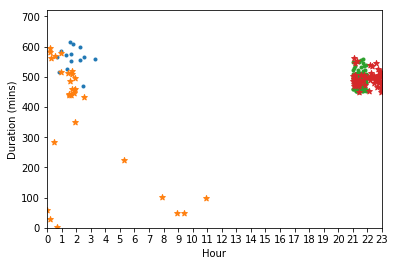

In [2]:
# Plot data points against start time 
plt.xlim(0, 23)
plt.xticks(range(24))
plt.ylim(0, 720)
plt.xlabel('Hour')
plt.ylabel('Duration (mins)')

plt.scatter(d1['Hour'], d1['Duration'], marker='.')
plt.scatter(d2['Hour'], d2['Duration'], marker='*')
plt.scatter(d3['Hour'], d3['Duration'], marker='.')
plt.scatter(d4['Hour'], d4['Duration'], marker='*')
plt.show()



In [3]:
mad = lambda x: np.fabs(x - x.mean()).mean()

win_size = 2

#d2
d2['Day'] = d2['Start'].map(lambda x: x.dayofweek)
d2['Is_Weekend'] = d2['Day'].map(lambda x: 1 if x in [5, 6] else 0)
d2['D'] = d2['Duration']
d2['Mad'] = d2['D'].rolling(win_size, min_periods=1).apply(mad)
d2['Mean'] = d2['D'].rolling(win_size, min_periods=1).mean()
d2['Min'] = d2['D'].rolling(win_size, min_periods=1).min()
d2['Max'] = d2['D'].rolling(win_size, min_periods=1).max()
d2['Std'] = d2['D'].rolling(win_size, min_periods=1).std()
d2['Var'] = d2['D'].rolling(win_size, min_periods=1).var()
d2.head(5)

#d3
d3['Day'] = d3['Start'].map(lambda x: x.dayofweek)
d3['Is_Weekend'] = d3['Day'].map(lambda x: 1 if x in [5, 6] else 0)
d3['D'] = d3['Duration']
d3['Mad'] = d3['D'].rolling(win_size, min_periods=1).apply(mad)
d3['Mean'] = d3['D'].rolling(win_size, min_periods=1).mean()
d3['Min'] = d3['D'].rolling(win_size, min_periods=1).min()
d3['Max'] = d3['D'].rolling(win_size, min_periods=1).max()
d3['Std'] = d3['D'].rolling(win_size, min_periods=1).std()
d3['Var'] = d3['D'].rolling(win_size, min_periods=1).var()
d3.head(5)

,Activity,Start,End,Duration,Hour,Day,Is_Weekend,D,Mad,Mean,Min,Max,Std,Var
0,Sleeping,2010-12-29 21:27:00,2010-12-30 05:24:00,477,21.450000,2,0,477,0.0,477.0,477.0,477.0,NaN,NaN
1,Sleeping,2010-12-30 21:33:00,2010-12-31 05:15:00,462,21.550000,3,0,462,7.5,469.5,462.0,477.0,10.606602,112.5
2,Sleeping,2010-12-31 21:15:00,2011-01-01 05:38:00,503,21.250000,4,0,503,20.5,482.5,462.0,503.0,28.991378,840.5
3,Sleeping,2011-01-01 21:28:00,2011-01-02 05:56:00,508,21.466667,5,1,508,2.5,505.5,503.0,508.0,3.535534,12.5
4,Sleeping,2011-01-02 21:46:00,2011-01-03 06:10:00,504,21.766667,6,1,504,2.0,506.0,504.0,508.0,2.828427,8.0


In [260]:
d3_dataset = d3[['Hour', 'Day', 'Is_Weekend', 'Mad', 'Mean', 'Min', 'Max', 'Std', 'Var']].values
d3_dataset = d3[['Hour', 'D', 'Day', 'Is_Weekend']].values
d3_dataset = np.nan_to_num(d3_dataset)
d3_dataset = d3_dataset[1:-1, 0:]


d2_dataset = d2[['Hour', 'Day', 'Is_Weekend', 'Mad', 'Mean', 'Min', 'Max', 'Std', 'Var']].values
d2_dataset = d2[['Hour', 'D', 'Day', 'Is_Weekend']].values
d2_dataset = np.nan_to_num(d2_dataset)
d2_dataset = d2_dataset[1:-1, 0:]

d2_d3 = np.concatenate((d3_dataset, d2_dataset), axis=0)
d2_d3.shape

(124, 4)

In [261]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

d2_scaled = scaler.fit_transform(d2_dataset)

d3_scaled = scaler.fit_transform(d3_dataset)

#d2_d3_scaled = scaler.fit_transform(d2_d3)

In [262]:
from sklearn import svm
X_train = d3_scaled[:75, :]
X_test = d3_scaled[75:, :]
X_outliers = d2_scaled[:, :]

# fit the model
clf = svm.OneClassSVM(nu=0.01, kernel="rbf", gamma=0.1)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size


print(X_train.shape[0])
print(X_test.shape[0])
print(X_outliers.shape[0])
print(n_error_train)
print(n_error_test)
print(n_error_outliers)


75
22
27
2
1
25


In [236]:
xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))
# plot the line, the points, and the nearest vectors to the plane
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("Novelty Detection")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')

s = 40
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=s, edgecolors='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', s=s, edgecolors='k')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='gold', s=s,edgecolors='k')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a.collections[0], b1, b2, c], ["learned frontier", "training observations", "new regular observations", "new abnormal observations"],
           loc="upper left", prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel(
    "error train: %d/200 ; errors novel regular: %d/40 ; "
    "errors novel abnormal: %d/40"
    % (n_error_train, n_error_test, n_error_outliers))
plt.show()

ValueError: X.shape[1] = 2 should be equal to 9, the number of features at training time